# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

## Helper Functions

Below are some helper functions to develop the pipeline

In [2]:
def grayscale(img):
    """
    Applies the Grayscale transform
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """
    Applies the Canny transform
    """
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=3):
    """
    Applies a Gaussian Noise kernel
    """
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """  
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of an Edge detector.
        
    Returns an image with hough lines drawn and other with the raw lines.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines_merged = merge_lane_lines(lines,0.6*img.shape[0],img.shape[0])
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines_img_raw = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    draw_lines(line_img, lines_merged,[0, 255, 0],10)
    draw_lines(lines_img_raw, lines,[0, 255, 0],2)
    
    return line_img,lines_img_raw

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    initial_img * α + img * β + γ
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def get_slope_intercept(lines):
    """
    Get slope and intercept for every line
    """
    slopes = (lines[:,3] - lines[:,1]) / (lines[:,2] - lines[:,0] + 0.0000001)
    intercepts = ((lines[:, 3] + lines[:, 1]) - slopes * (lines[:, 2] + lines[:, 0])) / 2
    return slopes, intercepts

def merge_lane_lines(lines,top,bottom):
    """
    Merge the lines, filtering by their slope and intercept.
    
    Note that filtering by their mean is not necessary when the ROI is accurate,
    in other cases, it helps.
    
    Returns the right and left lines
    """
    #0. Define variables
    top = int(top)
    bottom = int(bottom)
    
    min_abs_slope = 0.4
    max_abs_slope = 0.9
    intercept_similarity_threshold = 20
    slope_similarity_threshold = 0.1
    
    #1. Get Slopes and intercepts of each line
    lines = lines[:,0,:]
    slopes, intercepts = get_slope_intercept(lines)
    
    #2. Get each cluster (left and right) and compute their mean values
    left_lines_idx = (slopes < -1*min_abs_slope) & (slopes > -1*max_abs_slope)
    left_slopes = slopes[left_lines_idx]
    left_intercepts = intercepts[left_lines_idx]
    left_mean_slope = np.mean(left_slopes)
    left_mean_intercepts = np.mean(left_intercepts)

    right_lines_idx = (slopes > min_abs_slope) & (slopes < max_abs_slope)
    right_slopes = slopes[right_lines_idx]
    right_intercepts = intercepts[right_lines_idx]
    right_mean_slope = np.mean(right_slopes)
    right_mean_intercepts = np.mean(right_intercepts)
    
    #3. Filter the slope and intercept by their mean and compute the mean values and LPF
    """
    filtered_left_lines_idx = (((left_slopes < left_mean_slope + slope_similarity_threshold) |
                            (left_slopes > left_mean_slope - slope_similarity_threshold)) &
                            ((left_intercepts < left_mean_intercepts + intercept_similarity_threshold) |
                            (left_intercepts > left_mean_intercepts - intercept_similarity_threshold)))
    
    filtered_right_lines_idx = (((right_slopes < right_mean_slope + slope_similarity_threshold) |
                            (right_slopes > right_mean_slope - slope_similarity_threshold)) &
                            ((right_intercepts < right_mean_intercepts + intercept_similarity_threshold) |
                            (right_intercepts > right_mean_intercepts - intercept_similarity_threshold)))
    
    left_mean_slope = np.mean(left_slopes[filtered_left_lines_idx])
    left_mean_intercepts = np.mean(left_intercepts[filtered_left_lines_idx])
    
    right_mean_slope = np.mean(right_slopes[filtered_right_lines_idx])
    right_mean_intercepts = np.mean(right_intercepts[filtered_right_lines_idx])
    """
    
    
    lpf_slope_l,lpf_slope_r,lpf_inter_l,lpf_inter_r = lowPassFilter(left_mean_slope,right_mean_slope,
                                                                    left_mean_intercepts,right_mean_intercepts)

    #5. Compute the new lines using: x = (y - intercept) / slope    
    left_line  = [int((top-lpf_inter_l)/lpf_slope_l),top,
                  int((bottom-lpf_inter_l)/lpf_slope_l),bottom]
    right_line = [int((top-lpf_inter_r)/lpf_slope_r),top,
                  int((bottom-lpf_inter_r)/lpf_slope_r),bottom]
        
    return np.array([[left_line], [right_line]])

def lowPassFilter(slope_left,slope_right,intercept_left,intercept_right):
    """
    Low pass filter to get lines estability 
    """
    global prev_data_left_slope
    global prev_data_right_slope
    global prev_data_left_intercept
    global prev_data_right_intercept
    global update_index
    global filter_order
    global error
    
    if (math.isnan(slope_left) or math.isnan(slope_right)):
        lpf_slope_left = prev_data_left_slope[update_index]
        lpf_slope_right =  prev_data_right_slope[update_index]
        lpf_intercept_left = prev_data_left_intercept[update_index]
        lpf_intercept_right = prev_data_right_intercept[update_index]
        error = True
    
    elif (update_index > 0 and (abs(slope_left-prev_data_left_slope[update_index-1]) > 0.1 or abs(slope_right-prev_data_right_slope[update_index-1]) > 0.1)):
        lpf_slope_left = prev_data_left_slope[update_index]
        lpf_slope_right =  prev_data_right_slope[update_index]
        lpf_intercept_left = prev_data_left_intercept[update_index]
        lpf_intercept_right = prev_data_right_intercept[update_index]
        error = True
    
    else:
        if (len(prev_data_left_slope) <= filter_order):
            prev_data_left_slope.append(slope_left)
            prev_data_right_slope.append(slope_right)
            prev_data_left_intercept.append(intercept_left)
            prev_data_right_intercept.append(intercept_right)
            update_index += 1
        else:
            if (update_index >= filter_order):
                update_index = 0
            else:
                update_index +=1
            
            prev_data_left_slope[update_index] = slope_left
            prev_data_right_slope[update_index] = slope_right
            prev_data_left_intercept[update_index] = intercept_left
            prev_data_right_intercept[update_index] = intercept_right

        lpf_slope_left = sum(prev_data_left_slope)/len(prev_data_left_slope)
        lpf_slope_right = sum(prev_data_right_slope)/len(prev_data_right_slope)
        lpf_intercept_left = sum(prev_data_left_intercept)/len(prev_data_left_intercept)
        lpf_intercept_right = sum(prev_data_right_intercept)/len(prev_data_right_intercept)
        error = False
    
    return lpf_slope_left,lpf_slope_right,lpf_intercept_left,lpf_intercept_right
            
def resetData():
    global prev_data_left_slope
    global prev_data_right_slope
    global prev_data_left_intercept
    global prev_data_right_intercept
    global update_index
    global filter_order
    global error
    
    prev_data_left_slope = []
    prev_data_right_slope = []
    prev_data_left_intercept = []
    prev_data_right_intercept = []
    filter_order = 10
    update_index = -1
    error = False
    
def adjust_gamma(image, gamma=1.0):
    """
    Apply gamma correction using the lookup table
    """
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

## Build a Lane Finding Pipeline

**Test Images**


In [3]:
path_in = "test_images/"
path_out = "experiments/"
img_names = os.listdir(path_in)
img_names

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

### Step 1: GrayScale, darken, colour space and color threshold

**GrayScale and Darken and Color space**

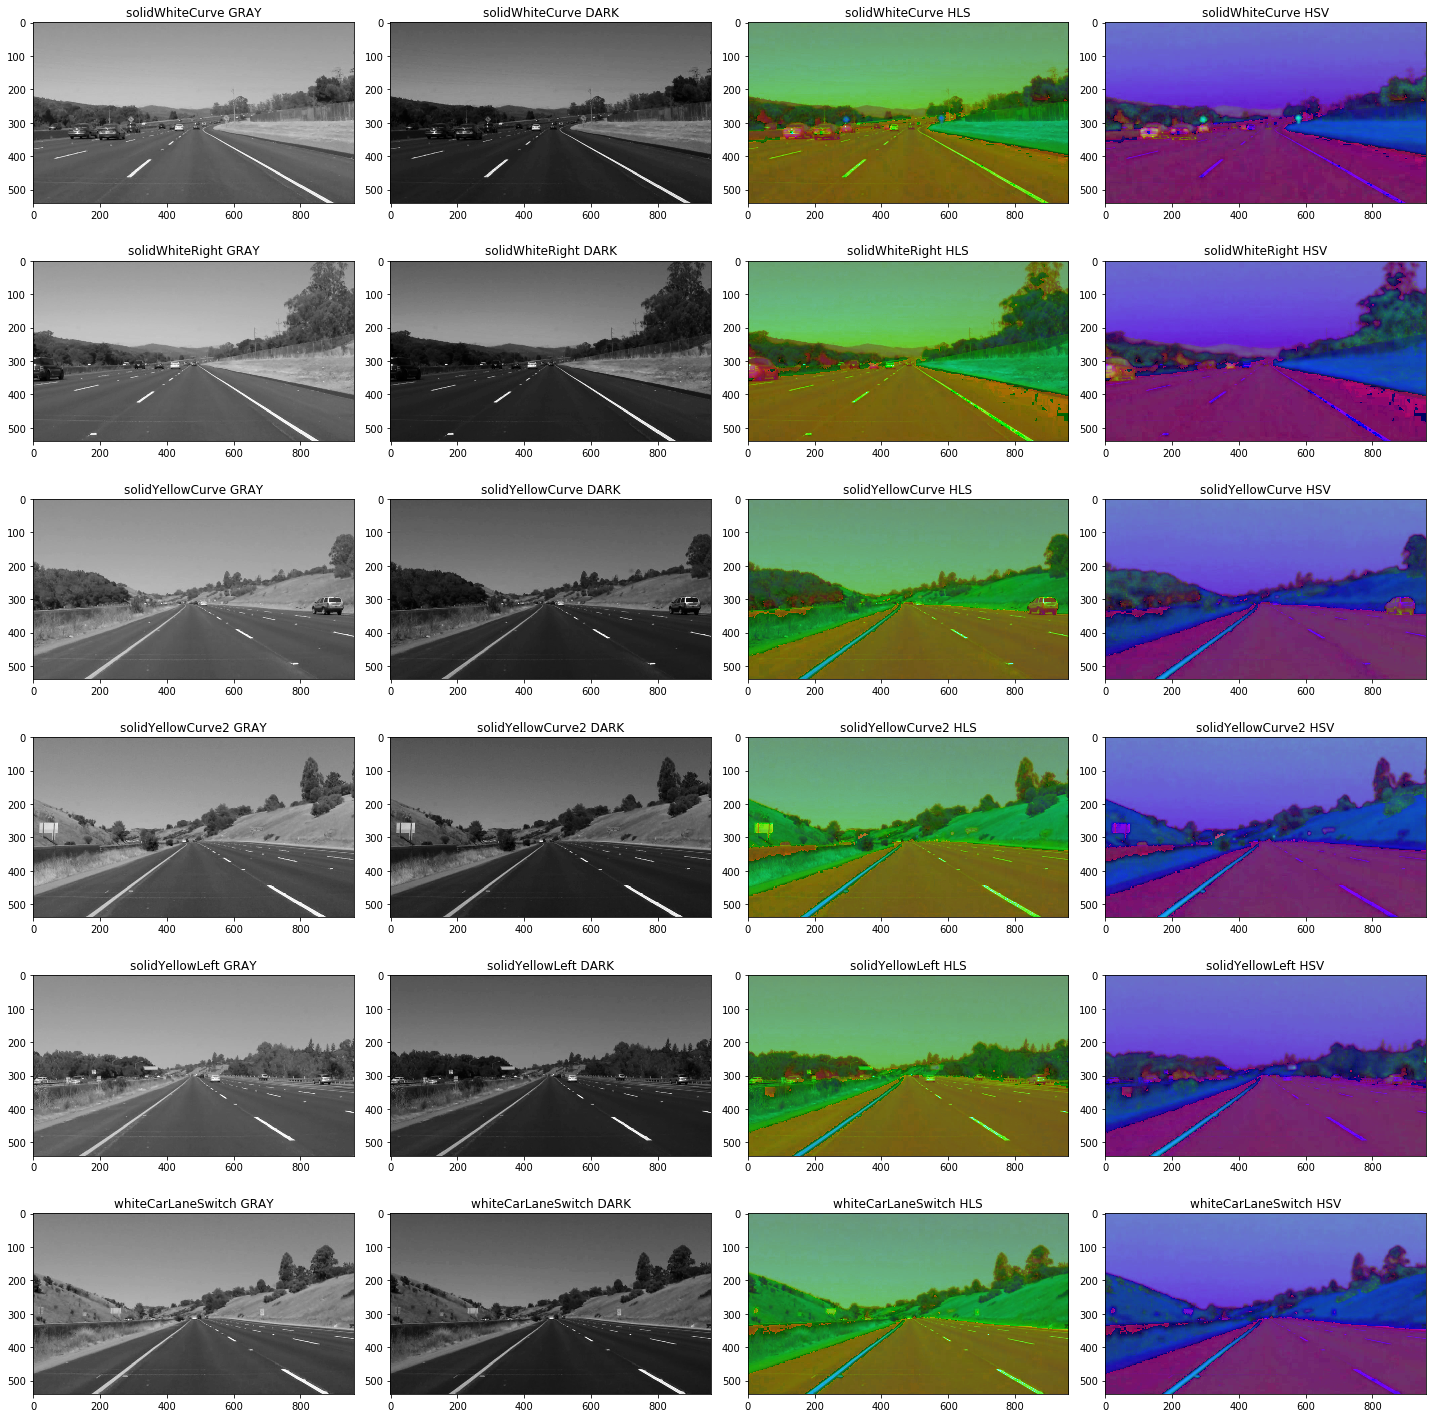

In [8]:
i=1
images = []
grays = []
darkened_grays = []
hsl_images = []

plt.figure(figsize=(20,20))
for img_name in img_names:
    image = cv2.imread(path_in+img_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    gray = grayscale(image)
    darkened_gray = adjust_gamma(gray, 0.5)

    hsl_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    images.append(image)
    grays.append(gray)
    darkened_grays.append(darkened_gray)
    hsl_images.append(hsl_image)
    
    plt.subplot(6,4,i)
    plt.title(img_name[:-4] + " GRAY")
    plt.imshow(gray, cmap='gray')
    cv2.imwrite(path_out+"1_gray_"+img_name,gray)
    i += 1
    plt.subplot(6,4,i)
    plt.title(img_name[:-4] + " DARK")
    plt.imshow(darkened_gray, cmap='gray')
    cv2.imwrite(path_out+"2_dark_"+img_name,darkened_gray)
    i += 1
    plt.subplot(6,4,i)
    plt.title(img_name[:-4] + " HLS")
    plt.imshow(hsl_image)
    cv2.imwrite(path_out+"3_hls_"+img_name,hsl_image)
    i += 1
    plt.subplot(6,4,i)
    plt.title(img_name[:-4] + " HSV")
    plt.imshow(hsv_image)
    i += 1
        
plt.tight_layout()
plt.show()


**HLS Colour threshold and final mask**

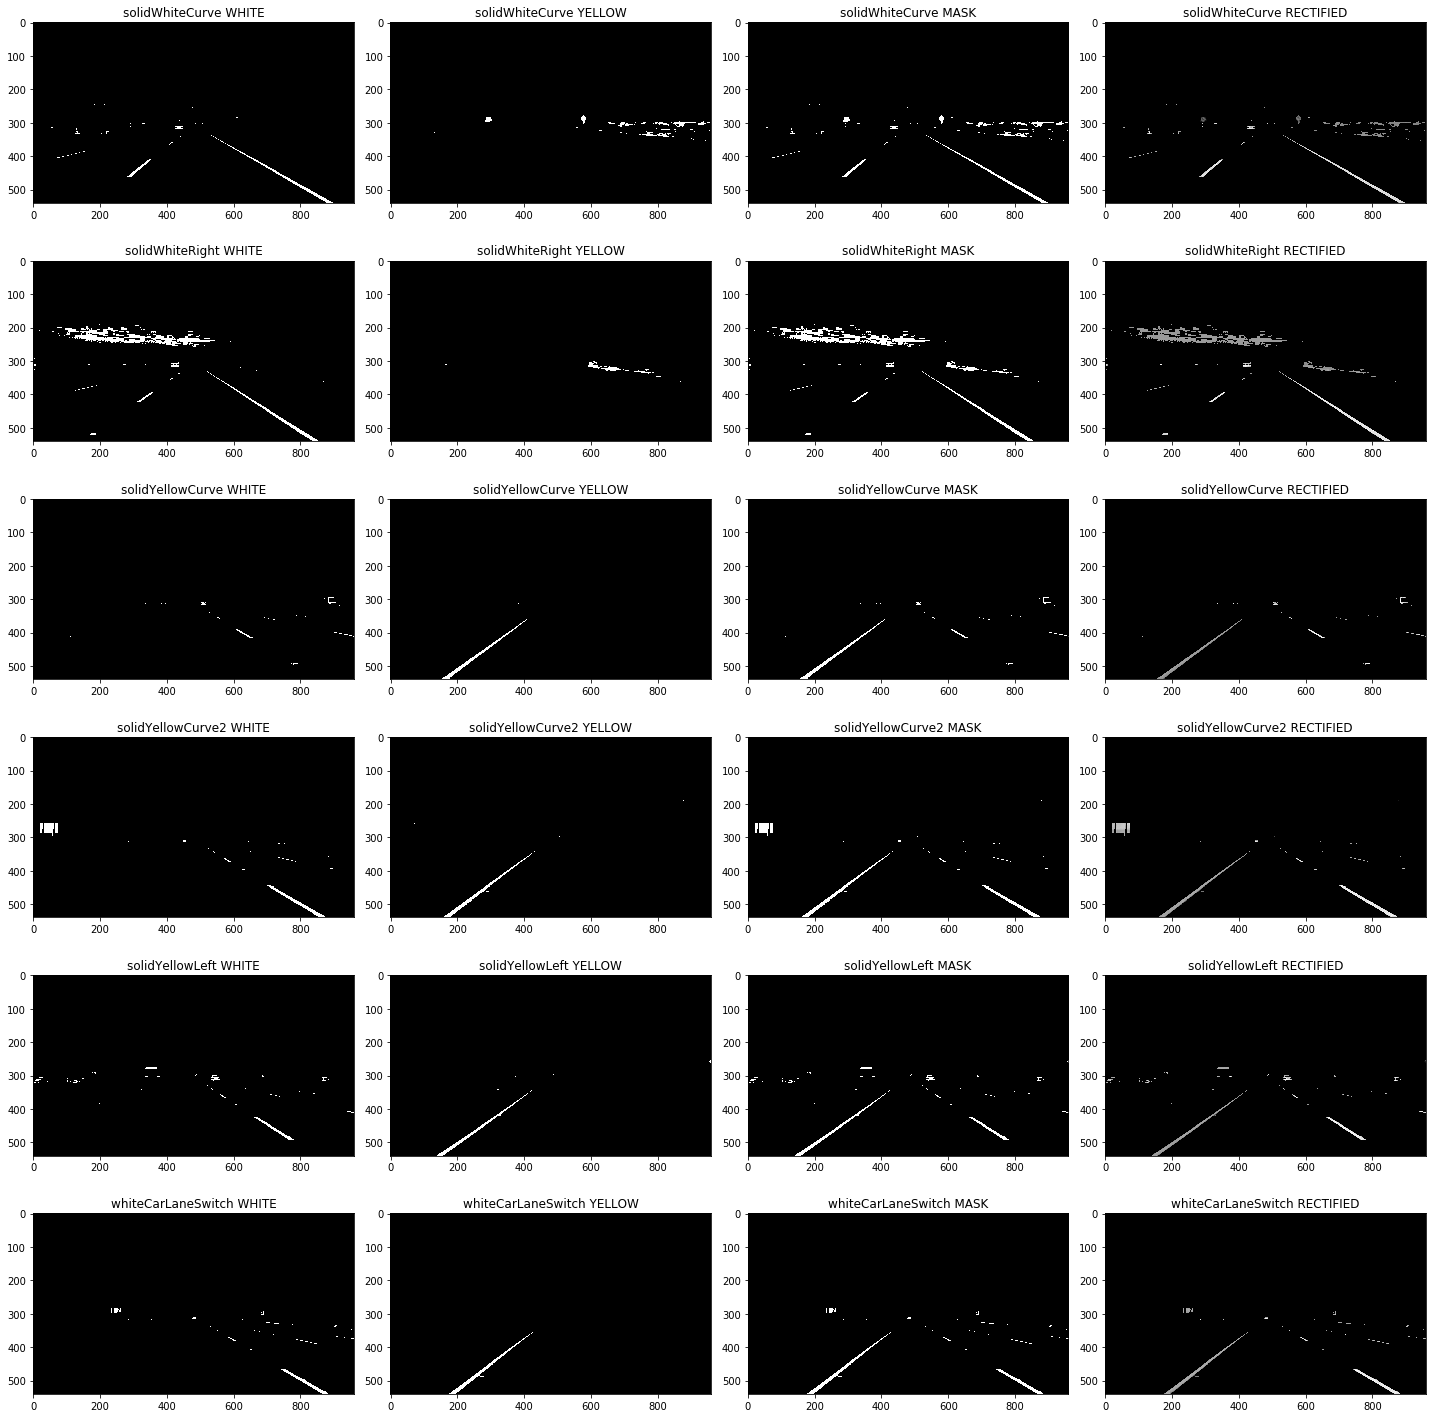

In [11]:
i = 1
j = 0

white_threshold = ((0, 200, 0),(200, 255, 255))
yellow_threshold = ((10, 0, 100),(40, 255, 255))

rectified_masks = []

plt.figure(figsize=(20,20))
for img_name in img_names:
    
    white_mask = cv2.inRange(hsl_images[j], white_threshold[0], white_threshold[1])
    yellow_mask = cv2.inRange(hsl_images[j], yellow_threshold[0], yellow_threshold[1])

    color_mask = white_mask | yellow_mask
    
    rectified_mask = cv2.bitwise_and(darkened_grays[j], darkened_grays[j], mask=color_mask)
    
    rectified_masks.append(rectified_mask)
    j += 1
    
    plt.subplot(6,4,i)
    plt.title(img_name[:-4] + " WHITE")
    plt.imshow(white_mask, cmap='gray')
    cv2.imwrite(path_out+"4_white_"+img_name,white_mask)
    i += 1
    plt.subplot(6,4,i)
    plt.title(img_name[:-4] + " YELLOW")
    plt.imshow(yellow_mask, cmap='gray')
    cv2.imwrite(path_out+"5_yellow_"+img_name,yellow_mask)
    i += 1
    plt.subplot(6,4,i)
    plt.title(img_name[:-4] + " MASK")
    plt.imshow(color_mask, cmap='gray')
    cv2.imwrite(path_out+"6_mask_"+img_name,color_mask)
    i += 1
    plt.subplot(6,4,i)
    plt.title(img_name[:-4] + " RECTIFIED")
    plt.imshow(rectified_mask, cmap='gray')
    cv2.imwrite(path_out+"7_rectified_"+img_name,rectified_mask)
    i += 1

plt.tight_layout()
plt.show()
    

### Step 2: Gaussian Blur and Edge Detection

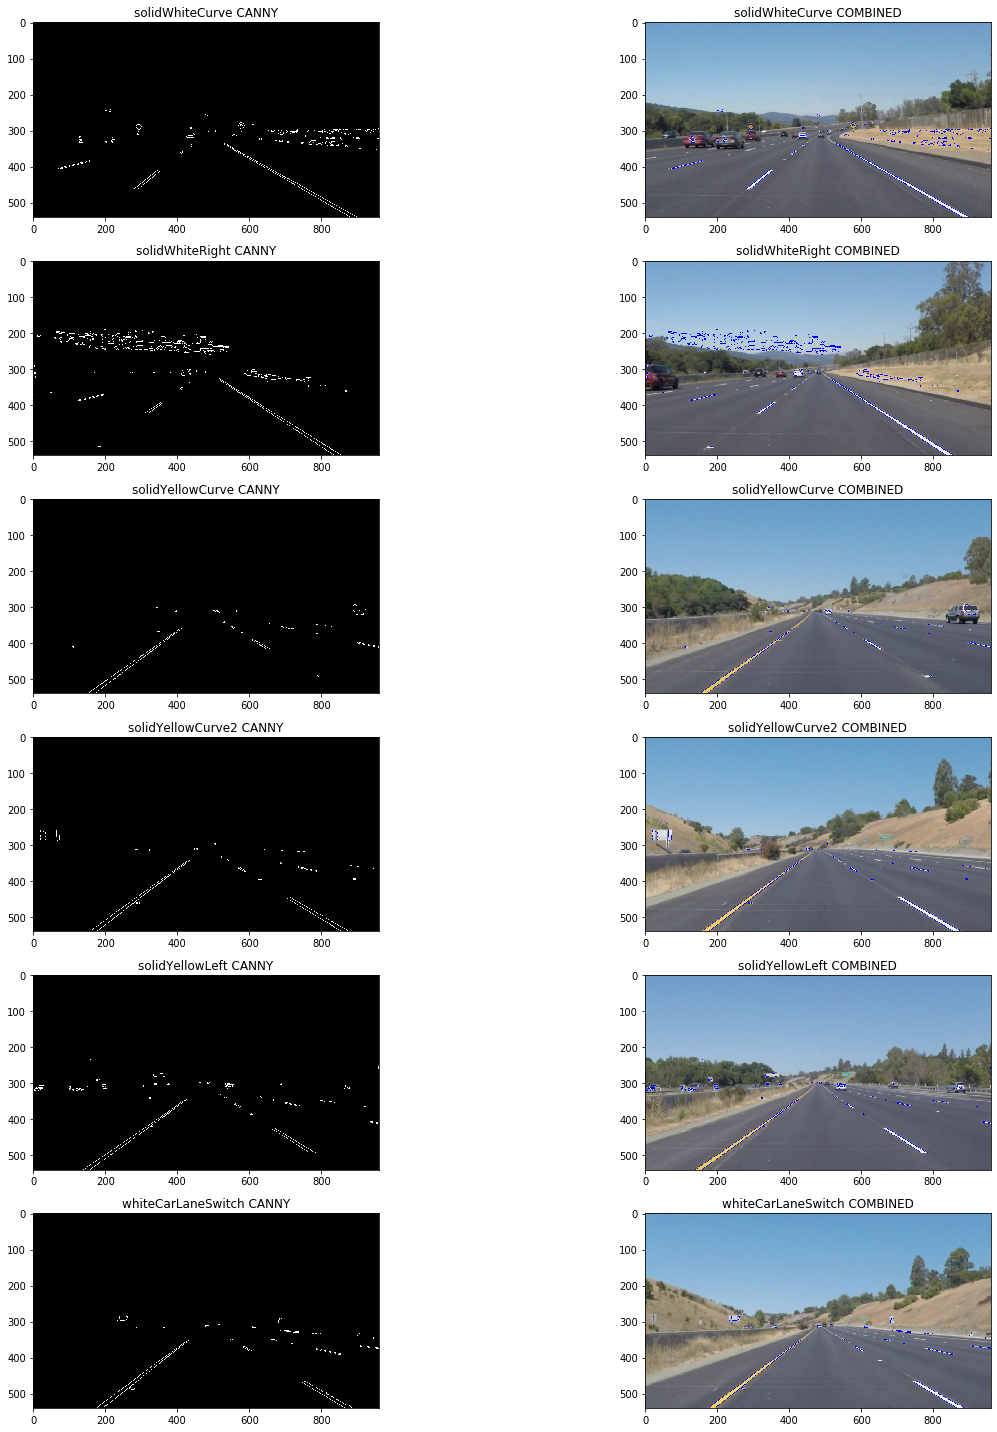

In [13]:
i = 1
j = 0

kernel_size = 5
low_threshold = 50
high_threshold = 150
    
canny_edges = []

plt.figure(figsize=(20,20))
for img_name in img_names:
    
    blur_gray =gaussian_blur(rectified_masks[j], kernel_size)
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    canny_edges.append(edges)
    
    edges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    combined = images[j].copy()
    combined[np.where((edges==[255,255,255]).all(axis=2))] = [0,0,255]
    
    j += 1
    
    plt.subplot(6,2,i)
    plt.title(img_name[:-4] + " CANNY")
    plt.imshow(edges)
    cv2.imwrite(path_out+"8_canny_"+img_name,edges)
    i += 1
    plt.subplot(6,2,i)
    plt.title(img_name[:-4] + " COMBINED")
    plt.imshow(combined)
    combined = cv2.cvtColor(combined, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path_out+"9_combined_"+img_name,combined)
    i += 1

plt.tight_layout()
plt.show()

### Step 3: Define region of interest

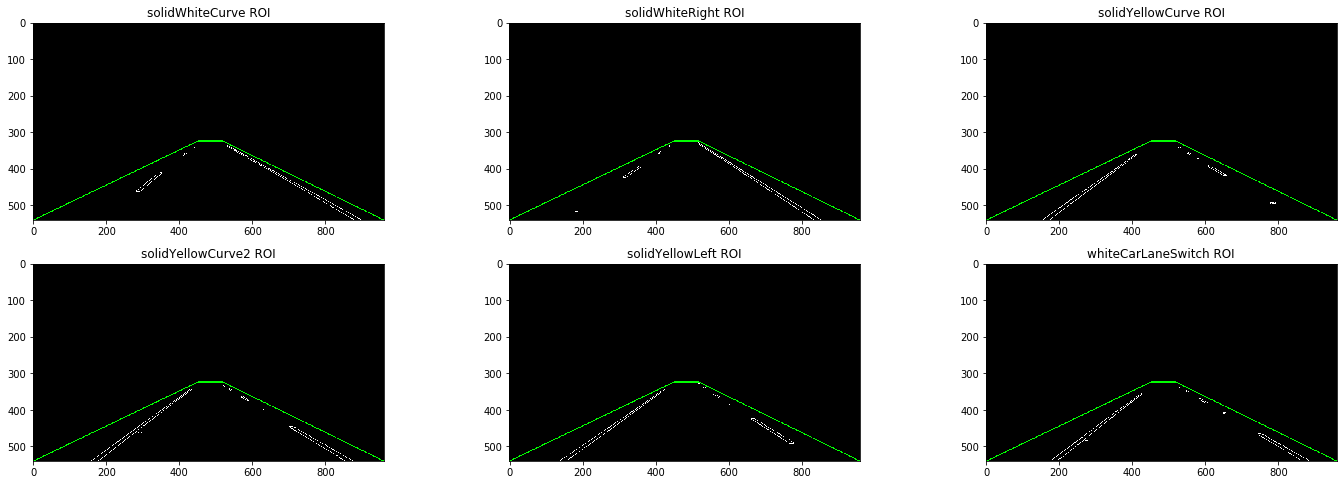

In [14]:
i = 1
j = 0

imshape = image.shape
vertices = np.array([[(0,imshape[0]),(0.47*imshape[1], 0.6*imshape[0]), (0.54*imshape[1], 0.6*imshape[0]), (imshape[1],imshape[0])]],dtype=np.int32)

rois_edges = []

plt.figure(figsize=(20,20))
for img_name in img_names:
    
    roi_edges = region_of_interest(canny_edges[j], vertices)
        
    rois_edges.append(roi_edges)
    j += 1
    
    roi_edges = cv2.cvtColor(roi_edges, cv2.COLOR_GRAY2BGR)
    pts = vertices
    pts = pts.reshape((-1,1,2))
    cv2.polylines(roi_edges,[pts],True,(0,255,0),2)
    
    plt.subplot(6,3,i)
    plt.title(img_name[:-4] + " ROI")
    plt.imshow(roi_edges)
    cv2.imwrite(path_out+"10_roi_"+img_name,roi_edges)
    i += 1
    
plt.tight_layout()
plt.show()

### Step 4: Hough Transform

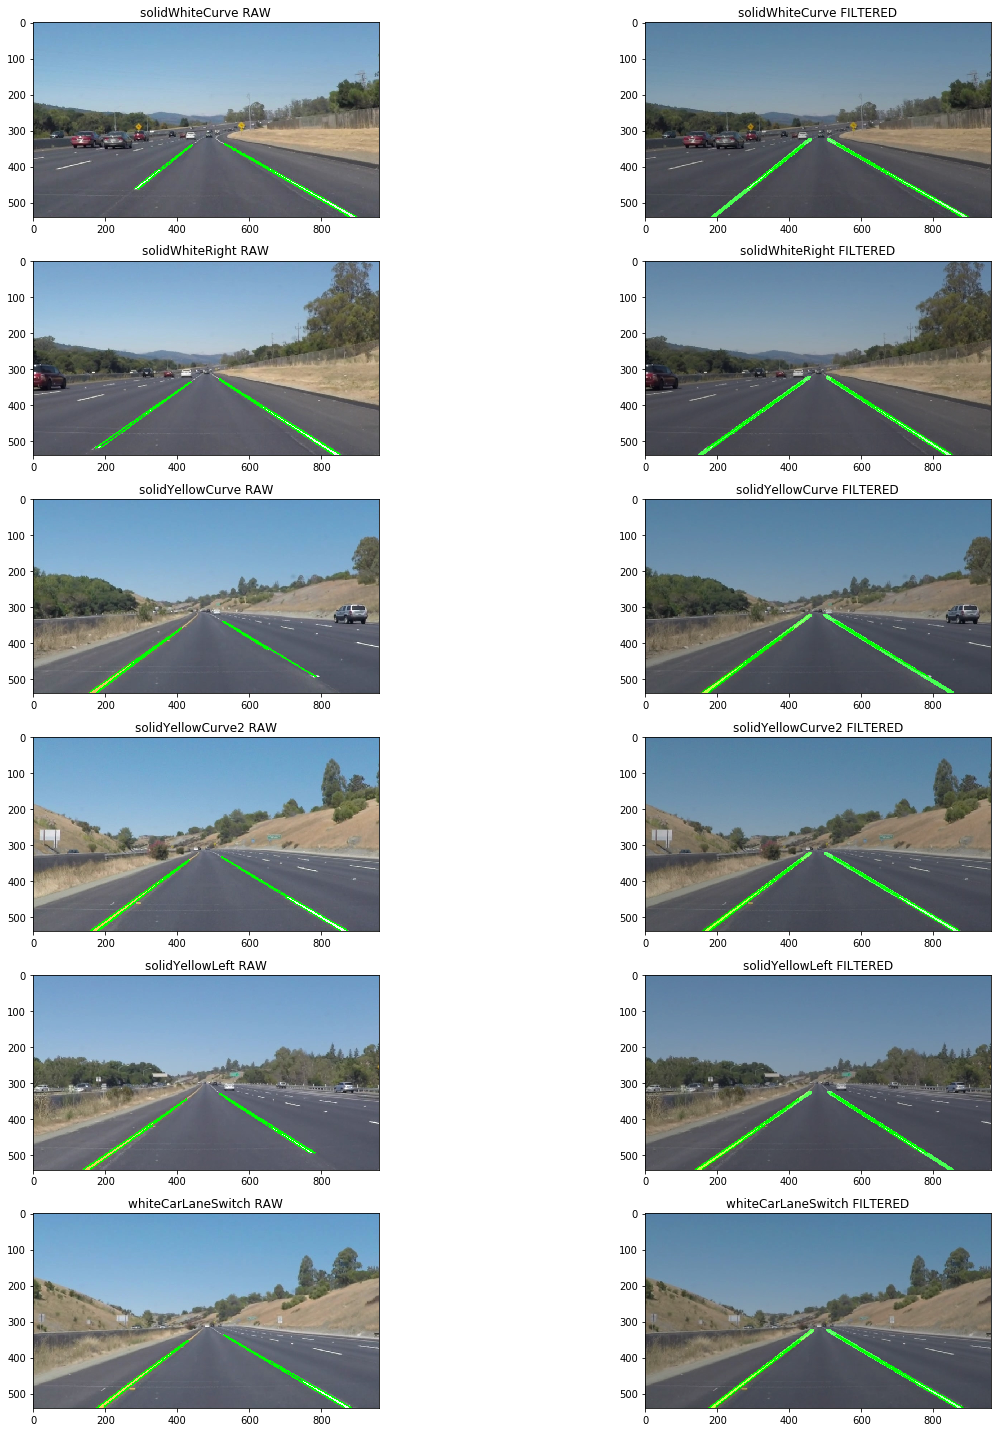

In [16]:
i = 1
j = 0

rho = 1              # distance resolution in pixels of the Hough grid
theta = np.pi/180    # angular resolution in radians of the Hough grid
threshold = 20       # minimum number of votes (intersections in Hough grid cell)
min_line_length = 20 #minimum number of pixels making up a line
max_line_gap = 200    # maximum gap in pixels between connectable line segments


plt.figure(figsize=(20,20))
for img_name in img_names:
    resetData()
    
    line_image,lines_image_raw = hough_lines(rois_edges[j], rho, theta, threshold,min_line_length, max_line_gap)
    result1 = weighted_img(line_image, images[j])
    
    result2 = images[j]
    result2[np.where((lines_image_raw==[0,255,0]).all(axis=2))] = [0,255,0] 
    
    j += 1
    
    plt.subplot(6,2,i)
    plt.title(img_name[:-4] + " RAW")
    plt.imshow(result2)
    result2 = cv2.cvtColor(result2, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path_out+"11_raw_"+img_name,result2)
    i += 1
    plt.subplot(6,2,i)
    plt.title(img_name[:-4] + " FILTERED")
    plt.imshow(result1)
    result1 = cv2.cvtColor(result1, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path_out+"12_filtered_"+img_name,result1)
    i += 1
    
plt.tight_layout()
plt.show()

## Completed Lane Finding Pipeline

In [39]:
prev_data_left_slope = []
prev_data_right_slope = []
prev_data_left_intercept = []
prev_data_right_intercept = []
filter_order = 10
update_index = -1
error = False

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    
    global error
    
    ## 1.GrayScale, darken, HLS space and color selection
    gray = grayscale(image)
    darkened_gray = adjust_gamma(gray, 0.5)
    
    hsl_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    white_threshold = ((0, 200, 0),(200, 255, 255))
    yellow_threshold = ((10, 0, 100),(40, 255, 255))
    
    white_mask = cv2.inRange(hsl_image, white_threshold[0], white_threshold[1])
    yellow_mask = cv2.inRange(hsl_image, yellow_threshold[0], yellow_threshold[1])

    color_mask = white_mask | yellow_mask
    
    rectified_mask = cv2.bitwise_and(darkened_gray, darkened_gray, mask=color_mask)
    
    ## 2. Gaussian smoothing and Edge detection
    kernel_size = 5
    low_threshold = 50
    high_threshold = 150

    blur_gray =gaussian_blur(rectified_mask, kernel_size)
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    ## 3. Define region of interest
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(0.47*imshape[1], 0.6*imshape[0]), (0.54*imshape[1], 0.6*imshape[0]), (imshape[1],imshape[0])]],dtype=np.int32)
    roi_edges = region_of_interest(edges, vertices)
    
    ## 4. Hough Transform
    rho = 1              # distance resolution in pixels of the Hough grid
    theta = np.pi/180    # angular resolution in radians of the Hough grid
    threshold = 20       # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 300    # maximum gap in pixels between connectable line segments
    
    try:
        line_image,lines_image_raw = hough_lines(roi_edges, rho, theta, threshold,min_line_length, max_line_gap)
        result = weighted_img(line_image, image)
        
        #result = image.copy()
        #result[np.where((lines_image_raw==[0,255,0]).all(axis=2))] = [0,255,0] 
    
        if (error):
            cv2.putText(result,'Error: Line detection',(10,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2,cv2.LINE_AA)
    except:
        result = image
        cv2.putText(result,'Error: Unexpected',(10,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2,cv2.LINE_AA)
        pass
    
    return result


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [40]:
resetData()
white_output = 'test_videos_output/solidWhiteRight_benchmarking.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("examples/P1_example.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   1%|          | 4/553 [00:00<00:15, 35.76it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight_benchmarking.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight_benchmarking.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight_benchmarking.mp4
CPU times: user 16.5 s, sys: 802 ms, total: 17.3 s
Wall time: 20.4 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [34]:
resetData()
yellow_output = 'test_videos_output/solidYellowLeft_raw.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|          | 3/681 [00:00<00:23, 29.47it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft_raw.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft_raw.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft_raw.mp4
CPU times: user 25.6 s, sys: 719 ms, total: 26.3 s
Wall time: 28.8 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge


In [38]:
resetData()
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   1%|          | 3/251 [00:00<00:08, 29.81it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 7.43 s, sys: 422 ms, total: 7.85 s
Wall time: 15.1 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))